In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import time

from sklearn.model_selection import cross_validate, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn import preprocessing, datasets
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

import mlrose_hiive


In [2]:
SEED = 2023
random.seed(SEED)

In [3]:
knapsack_len=100
knapsack_weights=np.random.uniform(0,10,knapsack_len)
knapsack_values=np.random.uniform(0,10,knapsack_len)
problem = mlrose_hiive.KnapsackOpt(weights=knapsack_weights, values=knapsack_values,
                                  max_weight_pct=0.5)

## Random Hill Climb

In [4]:
%%time

model_rhc = mlrose_hiive.RHCRunner(problem, experiment_name="RHC", 
                                       iteration_list=[10000],
                                       seed=SEED, max_attempts=20, 
                                       restart_list=[20])
rhc_stats, rhc_curves = model_rhc.run()

CPU times: user 197 ms, sys: 9.87 ms, total: 207 ms
Wall time: 201 ms


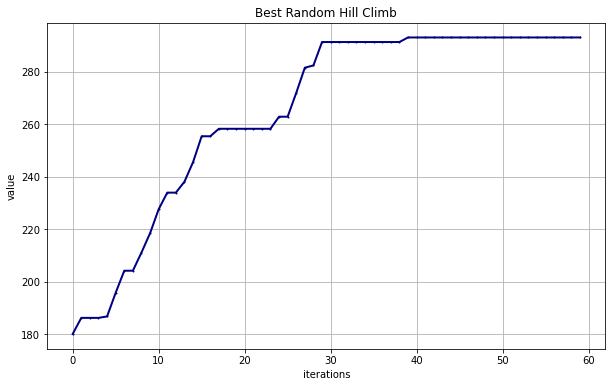

In [6]:
best_idx = rhc_curves.Fitness.idxmax()
best_decay = rhc_curves.iloc[best_idx].current_restart
best_curve = rhc_curves.loc[rhc_curves.current_restart == best_decay, :]
best_curve.reset_index(inplace=True)
best_decay

ax = best_curve.Fitness.plot(lw=2, colormap='jet', marker='.', markersize=2, 
                             figsize=(10,6), grid=1,
                             title='Best Random Hill Climb')
ax.set_xlabel("iterations")
ax.set_ylabel("value")
plt.show()

In [7]:
last_iters = rhc_curves[rhc_curves.Iteration != 0].reset_index()
pd.DataFrame({'Fitness': {'max': last_iters.Fitness.max(), 'mean': last_iters.Fitness.mean()},
             'Time': {'max': last_iters.Time.max(), 'mean': last_iters.Time.mean()}})



,Fitness,Time
max,292.954008,0.015181
mean,175.909556,0.005850


## Simulated Annealing

In [8]:
%%time
model_sa = mlrose_hiive.SARunner(problem, experiment_name="SA", 
                           iteration_list=[10000],
                           temperature_list=[1, 10, 50, 100, 250],
                           decay_list=[mlrose_hiive.ExpDecay,
                                       mlrose_hiive.GeomDecay],
                           seed=SEED, max_attempts=10)

sa_stats, sa_curves = model_sa.run()   

CPU times: user 712 ms, sys: 10.4 ms, total: 722 ms
Wall time: 721 ms


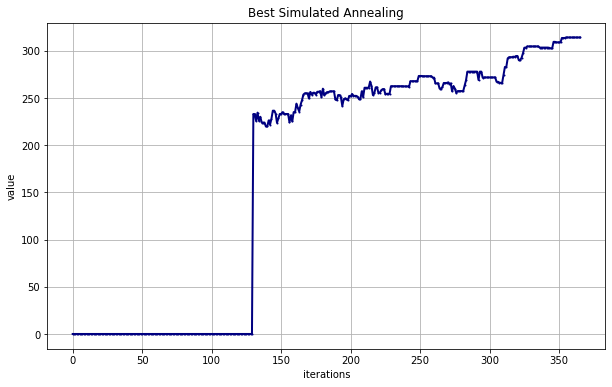

In [9]:
best_idx = sa_curves.Fitness.idxmax()
best_decay = sa_curves.iloc[best_idx].Temperature
best_curve = sa_curves.loc[sa_curves.Temperature == best_decay, :]
best_curve.reset_index(inplace=True)
best_decay

ax = best_curve.Fitness.plot(lw=2, colormap='jet', marker='.', markersize=2, 
                             figsize=(10,6), grid=1,
                             title='Best Simulated Annealing')
ax.set_xlabel("iterations")
ax.set_ylabel("value")
plt.show()

In [10]:
last_iters = sa_stats[sa_stats.Iteration != 0].reset_index()
pd.DataFrame({'Fitness': {'max': last_iters.Fitness.max(), 'mean': last_iters.Fitness.mean()},
             'Time': {'max': last_iters.Time.max(), 'mean': last_iters.Time.mean()}})


,Fitness,Time
max,314.249330,0.233515
mean,279.734446,0.067036


## Genetic Algo

In [4]:
%%time
model_ga = mlrose_hiive.GARunner(problem=problem,
                          experiment_name="GA",
                          seed=SEED,
                          iteration_list=[10000],
                          max_attempts=100,
                          population_sizes=[20,50,100],
                          mutation_rates=[0.1, 0.25, 0.5])
ga_stats, ga_curves = model_ga.run()   

CPU times: user 7.22 s, sys: 47.7 ms, total: 7.27 s
Wall time: 7.35 s


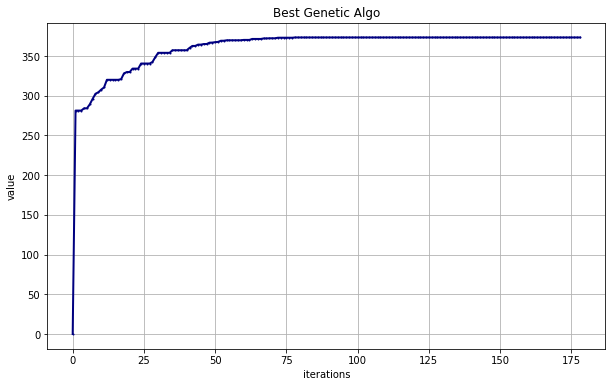

In [5]:
best_idx = ga_curves.Fitness.idxmax()
best_pop_size = ga_curves.iloc[best_idx]['Population Size']
best_mut_rate = ga_curves.iloc[best_idx]['Mutation Rate']
best_curve = ga_curves.loc[(ga_curves['Population Size'] == best_pop_size)&
                           (ga_curves['Mutation Rate'] == best_mut_rate), :]
best_curve.reset_index(inplace=True)

ax = best_curve.Fitness.iloc[:].plot(lw=2, colormap='jet', marker='.', markersize=2, 
                             figsize=(10,6), grid=1,
                             title='Best Genetic Algo')
ax.set_xlabel("iterations")
ax.set_ylabel("value")
plt.show()

In [6]:
last_iters = ga_stats[ga_stats.Iteration != 0].reset_index()
print('max:', last_iters.Fitness.max(), '\n', 
      'mean:', last_iters.Fitness.mean(), last_iters.Time.mean())
df1 = pd.DataFrame({"Mutation Rate": last_iters.groupby("Mutation Rate").Fitness.mean().to_dict()})
df1=df1.reset_index()
df1.columns=['Mutation Rate', 'Fitness']
df2 = pd.DataFrame({"Population Size": last_iters.groupby("Population Size").Fitness.mean().to_dict()})
df2=df2.reset_index()
df2.columns=['Population Size', 'Fitness']
pd.concat([df1,df2],axis=1)

max: 373.4743282535298 
 mean: 356.8231745835069 0.8117984256666533


,Mutation Rate,Fitness,Population Size,Fitness
0,0.10,350.780756,20,333.449296
1,0.25,351.806513,50,364.397730
2,0.50,367.882255,100,372.622498


##  MIMIC

In [7]:
%%time
model_mmc = mlrose_hiive.MIMICRunner(problem=problem,
                          experiment_name="MMC",
                          seed=SEED,
                          iteration_list=[100],
                          max_attempts=20,
                          population_sizes=[20,50,100],
                          keep_percent_list=[0.25, 0.5, 0.75],
                          use_fast_mimic=True)

mmc_stats, mmc_curves = model_mmc.run()

CPU times: user 8.01 s, sys: 564 ms, total: 8.57 s
Wall time: 8.59 s


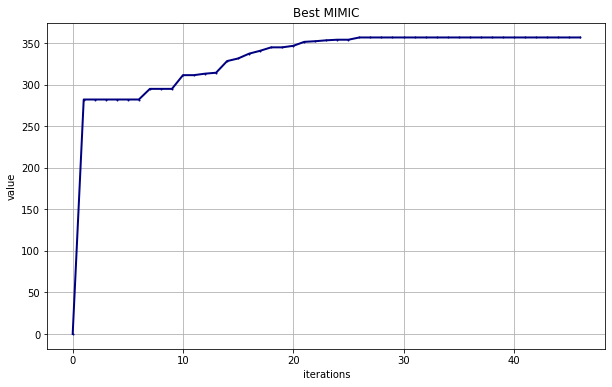

In [8]:
best_idx = mmc_curves.Fitness.idxmax()
best_pop_size = mmc_curves.iloc[best_idx]['Population Size']
best_keep_pct = mmc_curves.iloc[best_idx]['Keep Percent']
best_curve = mmc_curves.loc[(mmc_curves['Population Size'] == best_pop_size)&
                           (mmc_curves['Keep Percent'] == best_keep_pct), :]
best_curve.reset_index(inplace=True)

ax = best_curve.Fitness.plot(lw=2, colormap='jet', marker='.', markersize=2, 
                             figsize=(10,6), grid=1,
                             title='Best MIMIC')
ax.set_xlabel("iterations")
ax.set_ylabel("value")
plt.show()

In [9]:
last_iters = mmc_stats[mmc_stats.Iteration != 0].reset_index()
print('max:', last_iters.Fitness.max(), '\n', 
      'mean:', last_iters.Fitness.mean(), last_iters.Time.mean())
df1 = pd.DataFrame({"Keep Percent": last_iters.groupby("Keep Percent").Fitness.mean().to_dict()})
df1=df1.reset_index()
df1.columns=['Keep Percent', 'Fitness']
df2 = pd.DataFrame({"Population Size": last_iters.groupby("Population Size").Fitness.mean().to_dict()})
df2=df2.reset_index()
df2.columns=['Population Size', 'Fitness']
pd.concat([df1,df2],axis=1)

max: 356.6373226851617 
 mean: 297.9043116253745 0.9517904452221981


,Keep Percent,Fitness,Population Size,Fitness
0,0.25,302.487238,20,264.648831
1,0.50,309.178589,50,292.541834
2,0.75,282.047108,100,336.522270
